# Boston Housing Case Study: Temporal vs Random Split Analysis

This notebook implements the case study requirements:
- Train a regression model using the first 70% of data (older houses)
- Evaluate on the last 30% (newer houses)
- Compare results to a random split baseline
- Analyze why performance may differ across the two splits
- Suggest ways to improve robustness to temporal changes

## Dataset Overview

The Boston Housing Dataset contains 506 samples with 13 features:
- **Features**: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, B, LSTAT
- **Target**: MEDV (median house value in $1000s)

Note: Some MEDV values are censored at 50.0 (corresponding to $50,000)

## 1. Setup and Data Loading

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
RANDOM_STATE = 42

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# Load the dataset
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv('data/housing.csv', header=None, delimiter=r"\s+", names=column_names)

print(f"Dataset shape: {data.shape}")
print(f"Features: {list(data.columns[:-1])}")
print(f"Target: {data.columns[-1]}")
print("\nFirst few rows:")
data.head()

Dataset shape: (506, 14)
Features: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
Target: MEDV

First few rows:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [4]:
# Basic dataset information
print("Dataset Info:")
print(f"Total samples: {len(data)}")
print(f"Features: {data.shape[1]-1}")
print(f"Target variable: {data.columns[-1]}")
print(f"\nTarget statistics:")
print(data['MEDV'].describe())
print(f"\nCensored values (MEDV >= 50): {(data['MEDV'] >= 50).sum()} ({(data['MEDV'] >= 50).sum()/len(data)*100:.1f}%)")

Dataset Info:
Total samples: 506
Features: 13
Target variable: MEDV

Target statistics:
count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: MEDV, dtype: float64

Censored values (MEDV >= 50): 16 (3.2%)


## 2. Quick EDA (Exploratory Data Analysis)

In [5]:
# Check for missing values
print("Missing values:")
print(data.isnull().sum())

# Check data types
print("\nData types:")
print(data.dtypes)

Missing values:
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Data types:
CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object


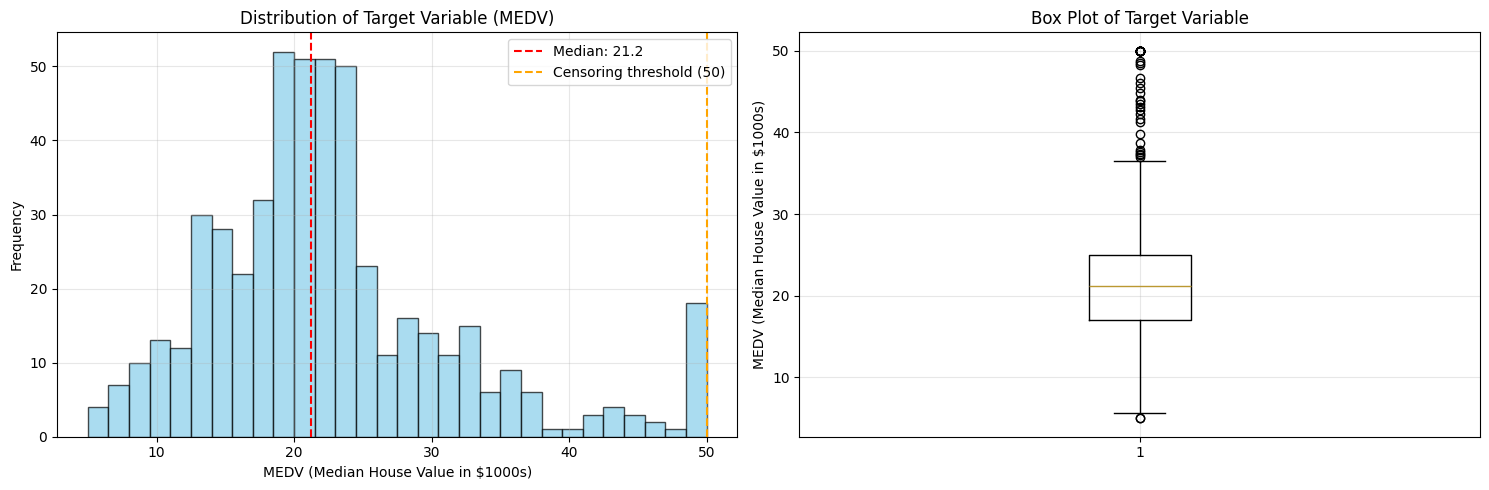

In [6]:
# Distribution of target variable
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
ax1.hist(data['MEDV'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(data['MEDV'].median(), color='red', linestyle='--', label=f'Median: {data["MEDV"].median():.1f}')
ax1.axvline(50, color='orange', linestyle='--', label='Censoring threshold (50)')
ax1.set_xlabel('MEDV (Median House Value in $1000s)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Target Variable (MEDV)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot
ax2.boxplot(data['MEDV'])
ax2.set_ylabel('MEDV (Median House Value in $1000s)')
ax2.set_title('Box Plot of Target Variable')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

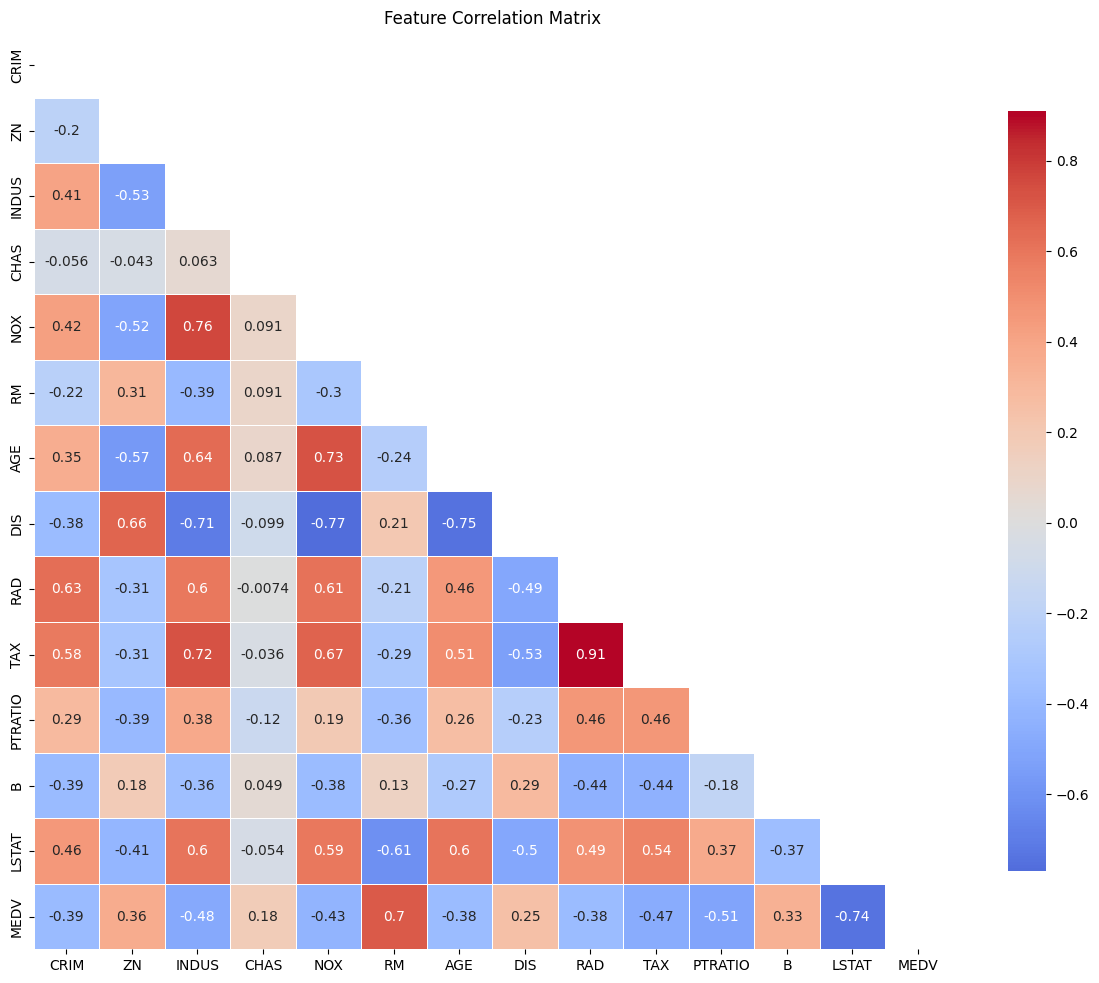

Top correlations with MEDV:
MEDV       1.000000
LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.388305
RAD        0.381626
AGE        0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: MEDV, dtype: float64


In [7]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Show top correlations with MEDV
medv_correlations = correlation_matrix['MEDV'].abs().sort_values(ascending=False)
print("Top correlations with MEDV:")
print(medv_correlations)

## 3. Data Preprocessing and Split Definitions

In [8]:
# Create two versions of the dataset as per design
# Version 1: Keep all rows (including censored values)
data_all = data.copy()

# Version 2: Remove rows with MEDV >= 50.0 (censored values)
data_clean = data[data['MEDV'] < 50.0].copy()

print(f"Version 1 (Keep all): {data_all.shape[0]} samples")
print(f"Version 2 (Remove censored): {data_clean.shape[0]} samples")
print(f"Removed {data_all.shape[0] - data_clean.shape[0]} censored samples")

Version 1 (Keep all): 506 samples
Version 2 (Remove censored): 490 samples
Removed 16 censored samples


In [9]:
# Define split functions
def create_chronological_split(data, train_ratio=0.7):
    """Create chronological split (first 70% vs last 30%)"""
    split_idx = int(len(data) * train_ratio)
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]
    return train_data, test_data

def create_age_based_split(data, train_ratio=0.7):
    """Create AGE-descending split (top 70% AGE vs bottom 30% AGE)"""
    data_sorted = data.sort_values('AGE', ascending=False)
    split_idx = int(len(data_sorted) * train_ratio)
    train_data = data_sorted.iloc[:split_idx]
    test_data = data_sorted.iloc[split_idx:]
    return train_data, test_data

def create_random_split(data, train_ratio=0.7, random_state=RANDOM_STATE):
    """Create random split baseline"""
    train_data, test_data = train_test_split(data, train_size=train_ratio, 
                                            random_state=random_state, shuffle=True)
    return train_data, test_data

def prepare_features_target(data, scale_features=True):
    """Prepare features and target, optionally scale features"""
    X = data.iloc[:, :-1]  # All features except MEDV
    y = data.iloc[:, -1]   # MEDV
    
    if scale_features:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        return X_scaled, y, scaler
    else:
        return X, y, None

In [10]:
# Create splits for both dataset versions
print("Creating splits for both dataset versions...")

# Version 1: Keep all data
print("\n=== Version 1: Keep All Data ===")
chrono_train_all, chrono_test_all = create_chronological_split(data_all)
age_train_all, age_test_all = create_age_based_split(data_all)
random_train_all, random_test_all = create_random_split(data_all)

print(f"Chronological split: {len(chrono_train_all)} train, {len(chrono_test_all)} test")
print(f"AGE-based split: {len(age_train_all)} train, {len(age_test_all)} test")
print(f"Random split: {len(random_train_all)} train, {len(random_test_all)} test")

# Version 2: Remove censored data
print("\n=== Version 2: Remove Censored Data ===")
chrono_train_clean, chrono_test_clean = create_chronological_split(data_clean)
age_train_clean, age_test_clean = create_age_based_split(data_clean)
random_train_clean, random_test_clean = create_random_split(data_clean)

print(f"Chronological split: {len(chrono_train_clean)} train, {len(chrono_test_clean)} test")
print(f"AGE-based split: {len(age_train_clean)} train, {len(age_test_clean)} test")
print(f"Random split: {len(random_train_clean)} train, {len(random_test_clean)} test")

Creating splits for both dataset versions...

=== Version 1: Keep All Data ===
Chronological split: 354 train, 152 test
AGE-based split: 354 train, 152 test
Random split: 354 train, 152 test

=== Version 2: Remove Censored Data ===
Chronological split: 343 train, 147 test
AGE-based split: 343 train, 147 test
Random split: 343 train, 147 test


## 4. Model Training and Evaluation

In [11]:
# Define evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """Train and evaluate a model, returning metrics"""
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {
        'model_name': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

# Define models
models = {
    'Ridge': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=3, 
        random_state=RANDOM_STATE
    )
}

In [12]:
# Evaluate models on all splits and dataset versions
results = []

print("Evaluating models on different splits and dataset versions...")
print("=" * 80)

# Version 1: Keep all data
print("\nVERSION 1: Keep All Data (including censored)")
print("-" * 50)

for split_name, (train_data, test_data) in [
    ('Chronological', (chrono_train_all, chrono_test_all)),
    ('AGE-based', (age_train_all, age_test_all)),
    ('Random', (random_train_all, random_test_all))
]:
    print(f"\n{split_name} Split:")
    
    # Prepare features and target
    X_train, y_train, scaler = prepare_features_target(train_data, scale_features=True)
    X_test, y_test, _ = prepare_features_target(test_data, scale_features=False)
    
    # Scale test features using train scaler
    if scaler is not None:
        X_test = scaler.transform(X_test)
    
    # Evaluate each model
    for model_name, model in models.items():
        # For tree-based models, don't scale features
        if model_name == 'GradientBoosting':
            X_train_raw, y_train_raw, _ = prepare_features_target(train_data, scale_features=False)
            X_test_raw, y_test_raw, _ = prepare_features_target(test_data, scale_features=False)
            result = evaluate_model(model, X_train_raw, X_test_raw, y_train_raw, y_test_raw, model_name)
        else:
            result = evaluate_model(model, X_train, X_test, y_train, y_test, model_name)
        
        result['dataset_version'] = 'Keep All'
        result['split_type'] = split_name
        results.append(result)
        
        print(f"  {model_name}: RMSE={result['rmse']:.3f}, MAE={result['mae']:.3f}, R²={result['r2']:.3f}")

# Version 2: Remove censored data
print("\n\nVERSION 2: Remove Censored Data")
print("-" * 50)

for split_name, (train_data, test_data) in [
    ('Chronological', (chrono_train_clean, chrono_test_clean)),
    ('AGE-based', (age_train_clean, age_test_clean)),
    ('Random', (random_train_clean, random_test_clean))
]:
    print(f"\n{split_name} Split:")
    
    # Prepare features and target
    X_train, y_train, scaler = prepare_features_target(train_data, scale_features=True)
    X_test, y_test, _ = prepare_features_target(test_data, scale_features=False)
    
    # Scale test features using train scaler
    if scaler is not None:
        X_test = scaler.transform(X_test)
    
    # Evaluate each model
    for model_name, model in models.items():
        # For tree-based models, don't scale features
        if model_name == 'GradientBoosting':
            X_train_raw, y_train_raw, _ = prepare_features_target(train_data, scale_features=False)
            X_test_raw, y_test_raw, _ = prepare_features_target(test_data, scale_features=False)
            result = evaluate_model(model, X_train_raw, X_test_raw, y_train_raw, y_test_raw, model_name)
        else:
            result = evaluate_model(model, X_train, X_test, y_train, y_test, model_name)
        
        result['dataset_version'] = 'Remove Censored'
        result['split_type'] = split_name
        results.append(result)
        
        print(f"  {model_name}: RMSE={result['rmse']:.3f}, MAE={result['mae']:.3f}, R²={result['r2']:.3f}")

Evaluating models on different splits and dataset versions...

VERSION 1: Keep All Data (including censored)
--------------------------------------------------

Chronological Split:
  Ridge: RMSE=23.056, MAE=15.187, R²=-7.012
  GradientBoosting: RMSE=7.258, MAE=4.866, R²=0.206

AGE-based Split:
  Ridge: RMSE=5.183, MAE=3.692, R²=0.490
  GradientBoosting: RMSE=3.230, MAE=2.515, R²=0.802

Random Split:
  Ridge: RMSE=4.642, MAE=3.161, R²=0.711
  GradientBoosting: RMSE=2.853, MAE=2.054, R²=0.891


VERSION 2: Remove Censored Data
--------------------------------------------------

Chronological Split:
  Ridge: RMSE=12.517, MAE=8.821, R²=-4.311
  GradientBoosting: RMSE=5.762, MAE=4.313, R²=-0.126

AGE-based Split:
  Ridge: RMSE=4.420, MAE=3.212, R²=0.541
  GradientBoosting: RMSE=2.948, MAE=2.266, R²=0.796

Random Split:
  Ridge: RMSE=3.593, MAE=2.777, R²=0.754
  GradientBoosting: RMSE=2.411, MAE=1.870, R²=0.889


In [13]:
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)
print("Complete Results Summary:")
print("=" * 80)
print(results_df.round(3))

# Save results for later analysis
results_df.to_csv('model_evaluation_results.csv', index=False)
print("\nResults saved to 'model_evaluation_results.csv'")

Complete Results Summary:
          model_name    rmse     mae     r2  dataset_version     split_type
0              Ridge  23.056  15.187 -7.012         Keep All  Chronological
1   GradientBoosting   7.258   4.866  0.206         Keep All  Chronological
2              Ridge   5.183   3.692  0.490         Keep All      AGE-based
3   GradientBoosting   3.230   2.515  0.802         Keep All      AGE-based
4              Ridge   4.642   3.161  0.711         Keep All         Random
5   GradientBoosting   2.853   2.054  0.891         Keep All         Random
6              Ridge  12.517   8.821 -4.311  Remove Censored  Chronological
7   GradientBoosting   5.762   4.313 -0.126  Remove Censored  Chronological
8              Ridge   4.420   3.212  0.541  Remove Censored      AGE-based
9   GradientBoosting   2.948   2.266  0.796  Remove Censored      AGE-based
10             Ridge   3.593   2.777  0.754  Remove Censored         Random
11  GradientBoosting   2.411   1.870  0.889  Remove Censored  

## 5. Results Analysis and Visualization

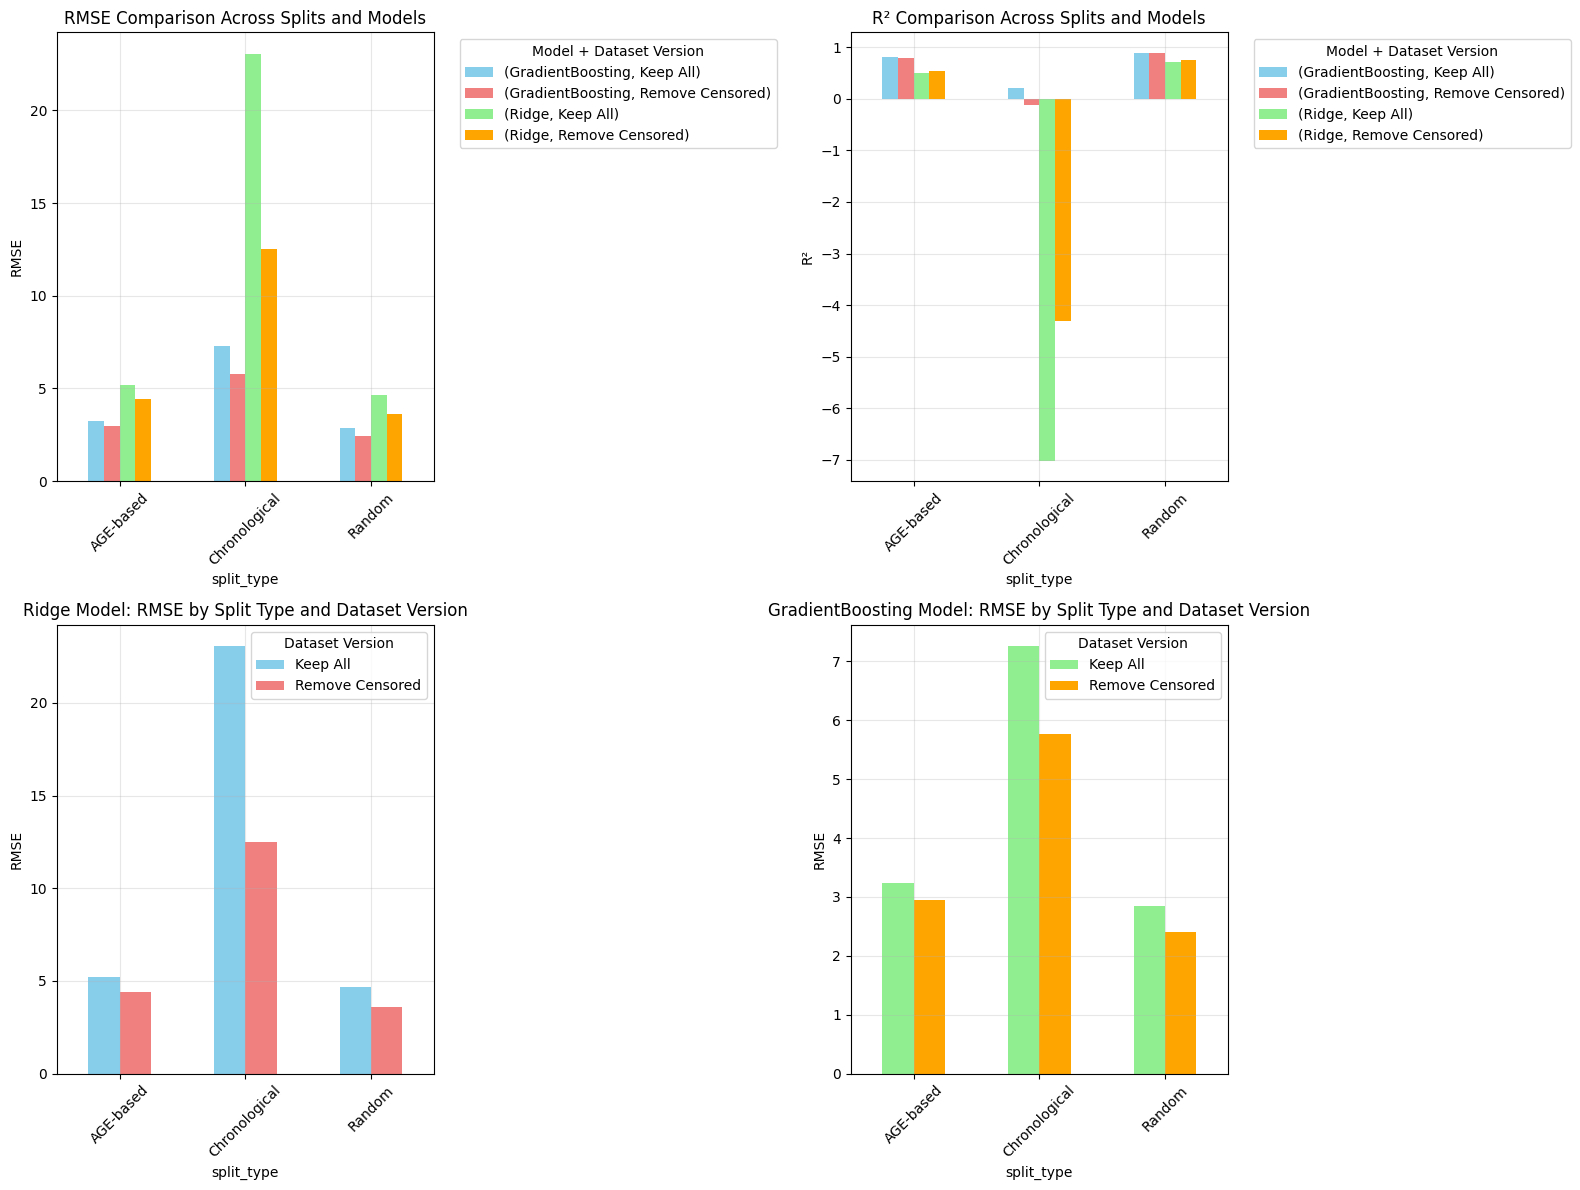

In [15]:
# Visualize results comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# 1. RMSE comparison across splits and models
ax1 = axes[0]
pivot_rmse = results_df.pivot_table(values='rmse', index='split_type', 
                                    columns=['model_name', 'dataset_version'], aggfunc='mean')
pivot_rmse.plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
ax1.set_title('RMSE Comparison Across Splits and Models')
ax1.set_ylabel('RMSE')
ax1.legend(title='Model + Dataset Version', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# 2. R² comparison
ax2 = axes[1]
pivot_r2 = results_df.pivot_table(values='r2', index='split_type', 
                                  columns=['model_name', 'dataset_version'], aggfunc='mean')
pivot_r2.plot(kind='bar', ax=ax2, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
ax2.set_title('R² Comparison Across Splits and Models')
ax2.set_ylabel('R²')
ax2.legend(title='Model + Dataset Version', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Model performance comparison (Ridge)
ax3 = axes[2]
ridge_results = results_df[results_df['model_name'] == 'Ridge']
ridge_pivot = ridge_results.pivot_table(values='rmse', index='split_type', 
                                       columns='dataset_version', aggfunc='mean')
ridge_pivot.plot(kind='bar', ax=ax3, color=['skyblue', 'lightcoral'])
ax3.set_title('Ridge Model: RMSE by Split Type and Dataset Version')
ax3.set_ylabel('RMSE')
ax3.legend(title='Dataset Version')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# 4. Model performance comparison (GradientBoosting)
ax4 = axes[3]
gbr_results = results_df[results_df['model_name'] == 'GradientBoosting']
gbr_pivot = gbr_results.pivot_table(values='rmse', index='split_type', 
                                    columns='dataset_version', aggfunc='mean')
gbr_pivot.plot(kind='bar', ax=ax4, color=['lightgreen', 'orange'])
ax4.set_title('GradientBoosting Model: RMSE by Split Type and Dataset Version')
ax4.set_ylabel('RMSE')
ax4.legend(title='Dataset Version')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Performance gap analysis
print("Performance Gap Analysis: Chronological vs Random Split")
print("=" * 60)

for dataset_version in ['Keep All', 'Remove Censored']:
    print(f"\n{dataset_version} Dataset:")
    
    for model_name in ['Ridge', 'GradientBoosting']:
        # Get results for chronological and random splits
        chrono_result = results_df[(results_df['dataset_version'] == dataset_version) & 
                                   (results_df['split_type'] == 'Chronological') & 
                                   (results_df['model_name'] == model_name)].iloc[0]
        
        random_result = results_df[(results_df['dataset_version'] == dataset_version) & 
                                   (results_df['split_type'] == 'Random') & 
                                   (results_df['model_name'] == model_name)].iloc[0]
        
        # Calculate performance gap
        rmse_gap = chrono_result['rmse'] - random_result['rmse']
        r2_gap = random_result['r2'] - chrono_result['r2']
        
        print(f"  {model_name}:")
        print(f"    RMSE gap (Chrono - Random): {rmse_gap:+.3f}")
        print(f"    R² gap (Random - Chrono): {r2_gap:+.3f}")
        
        if rmse_gap > 0:
            print(f"    → Chronological split performs WORSE by {rmse_gap:.3f} RMSE")
        else:
            print(f"    → Chronological split performs BETTER by {abs(rmse_gap):.3f} RMSE")

Performance Gap Analysis: Chronological vs Random Split

Keep All Dataset:
  Ridge:
    RMSE gap (Chrono - Random): +18.414
    R² gap (Random - Chrono): +7.723
    → Chronological split performs WORSE by 18.414 RMSE
  GradientBoosting:
    RMSE gap (Chrono - Random): +4.405
    R² gap (Random - Chrono): +0.685
    → Chronological split performs WORSE by 4.405 RMSE

Remove Censored Dataset:
  Ridge:
    RMSE gap (Chrono - Random): +8.924
    R² gap (Random - Chrono): +5.065
    → Chronological split performs WORSE by 8.924 RMSE
  GradientBoosting:
    RMSE gap (Chrono - Random): +3.351
    R² gap (Random - Chrono): +1.015
    → Chronological split performs WORSE by 3.351 RMSE


## 6. Drift and Error Analysis

In [17]:
# Analyze feature distribution shifts between train and test sets
print("Feature Distribution Shift Analysis: Chronological Split")
print("=" * 60)

# Focus on key features as per design
key_features = ['LSTAT', 'RM', 'NOX', 'DIS', 'RAD', 'TAX']

for dataset_version, (train_data, test_data) in [
    ('Keep All', (chrono_train_all, chrono_test_all)),
    ('Remove Censored', (chrono_train_clean, chrono_test_clean))
]:
    print(f"\n{dataset_version} Dataset:")
    
    for feature in key_features:
        train_mean = train_data[feature].mean()
        test_mean = test_data[feature].mean()
        train_std = train_data[feature].std()
        test_std = test_data[feature].std()
        
        mean_shift = test_mean - train_mean
        std_shift = test_std - train_std
        
        print(f"  {feature}:")
        print(f"    Mean: {train_mean:.3f} → {test_mean:.3f} (shift: {mean_shift:+.3f})")
        print(f"    Std:  {train_std:.3f} → {test_std:.3f} (shift: {std_shift:+.3f})")
        
        # Statistical significance test
        _, p_value = stats.ks_2samp(train_data[feature], test_data[feature])
        print(f"    KS test p-value: {p_value:.4f} {'(significant)' if p_value < 0.05 else '(not significant)'}")

Feature Distribution Shift Analysis: Chronological Split

Keep All Dataset:
  LSTAT:
    Mean: 10.370 → 17.971 (shift: +7.601)
    Std:  5.879 → 7.003 (shift: +1.124)
    KS test p-value: 0.0000 (significant)
  RM:
    Mean: 6.404 → 6.007 (shift: -0.397)
    Std:  0.674 → 0.691 (shift: +0.016)
    KS test p-value: 0.0010 (significant)
  NOX:
    Mean: 0.510 → 0.659 (shift: +0.149)
    Std:  0.102 → 0.069 (shift: -0.033)
    KS test p-value: 0.0000 (significant)
  DIS:
    Mean: 4.478 → 2.204 (shift: -2.274)
    Std:  2.057 → 1.138 (shift: -0.919)
    KS test p-value: 0.0000 (significant)
  RAD:
    Mean: 4.472 → 21.375 (shift: +16.903)
    Std:  1.609 → 6.804 (shift: +5.194)
    KS test p-value: 0.0000 (significant)
  TAX:
    Mean: 310.565 → 635.711 (shift: +325.146)
    Std:  68.032 → 98.612 (shift: +30.579)
    KS test p-value: 0.0000 (significant)

Remove Censored Dataset:
  LSTAT:
    Mean: 10.582 → 18.389 (shift: +7.807)
    Std:  5.844 → 6.714 (shift: +0.871)
    KS test p-value

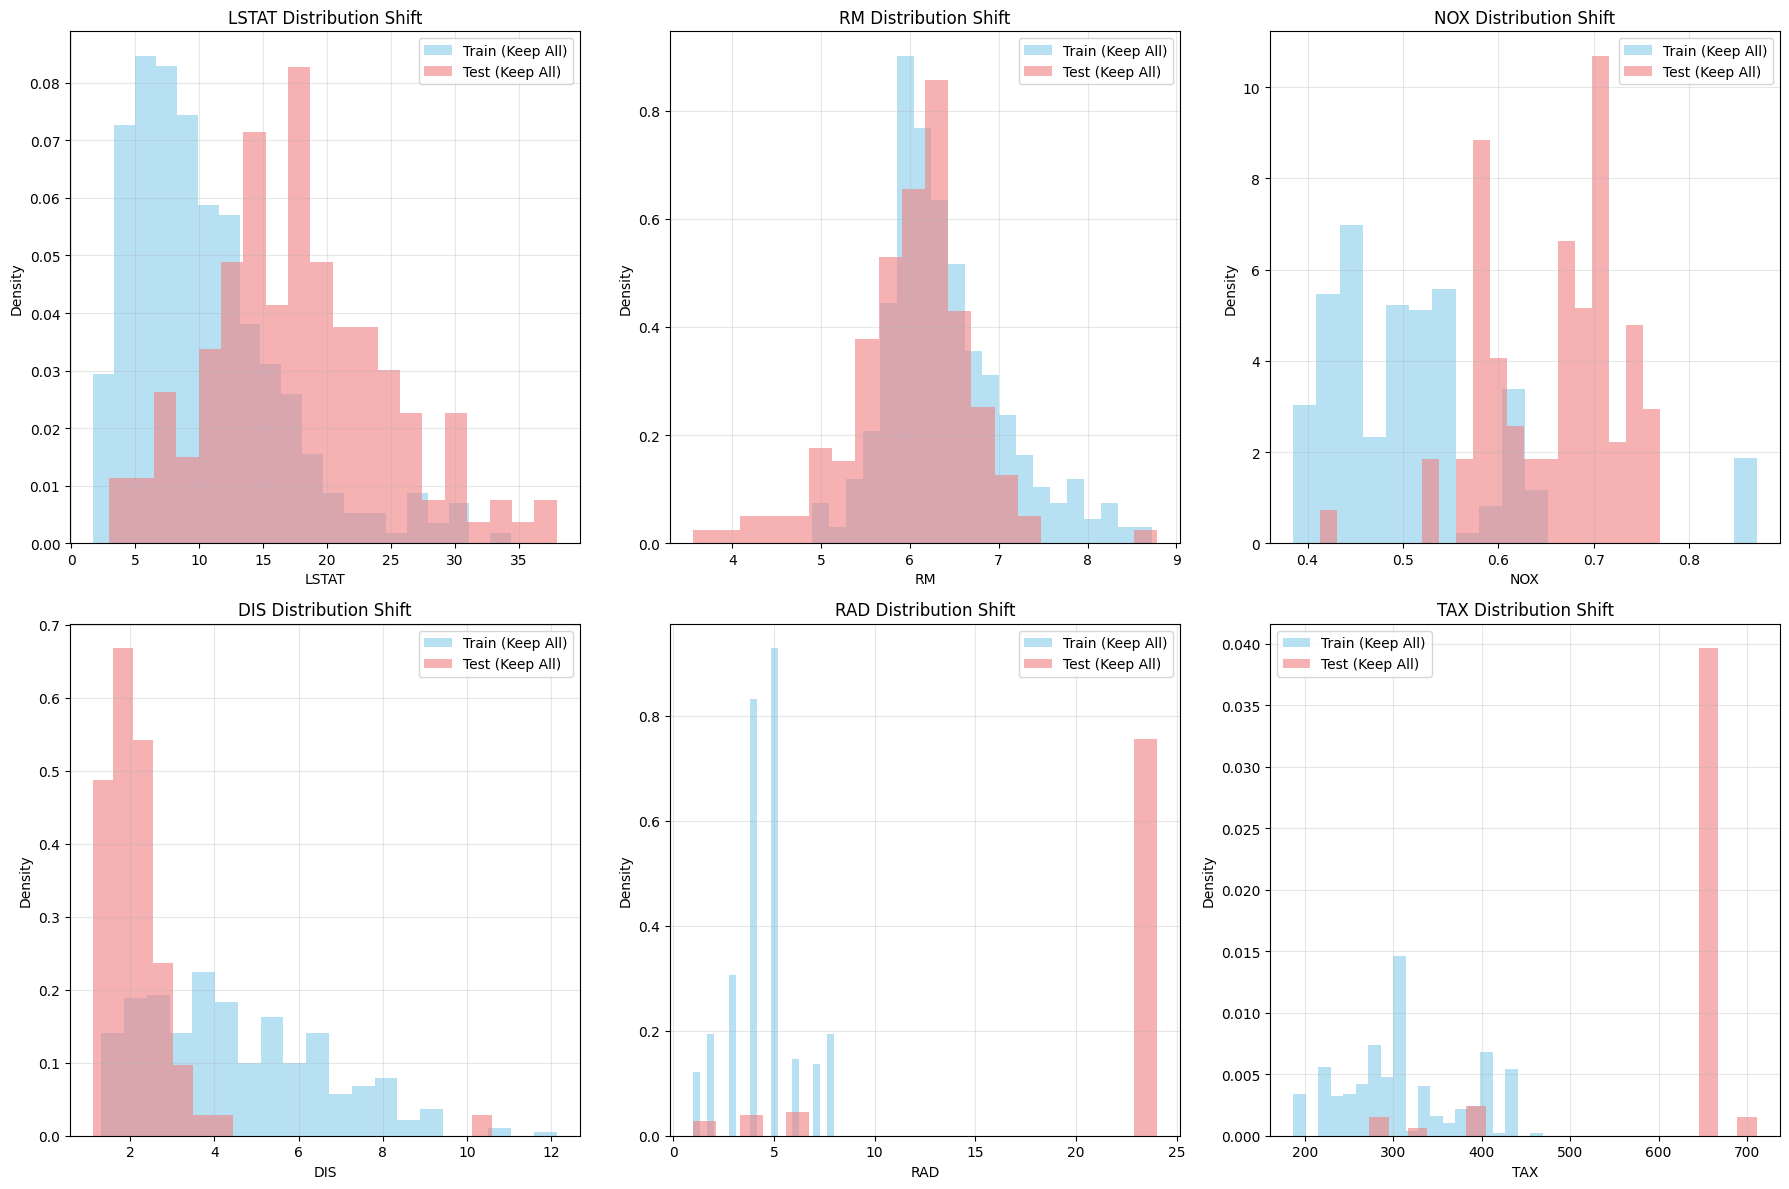

In [18]:
# Visualize distribution shifts for key features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    ax = axes[i]
    
    # Plot distributions for both dataset versions
    ax.hist(chrono_train_all[feature], bins=20, alpha=0.6, label='Train (Keep All)', 
             color='skyblue', density=True)
    ax.hist(chrono_test_all[feature], bins=20, alpha=0.6, label='Test (Keep All)', 
             color='lightcoral', density=True)
    
    ax.set_title(f'{feature} Distribution Shift')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Model Explainability Analysis


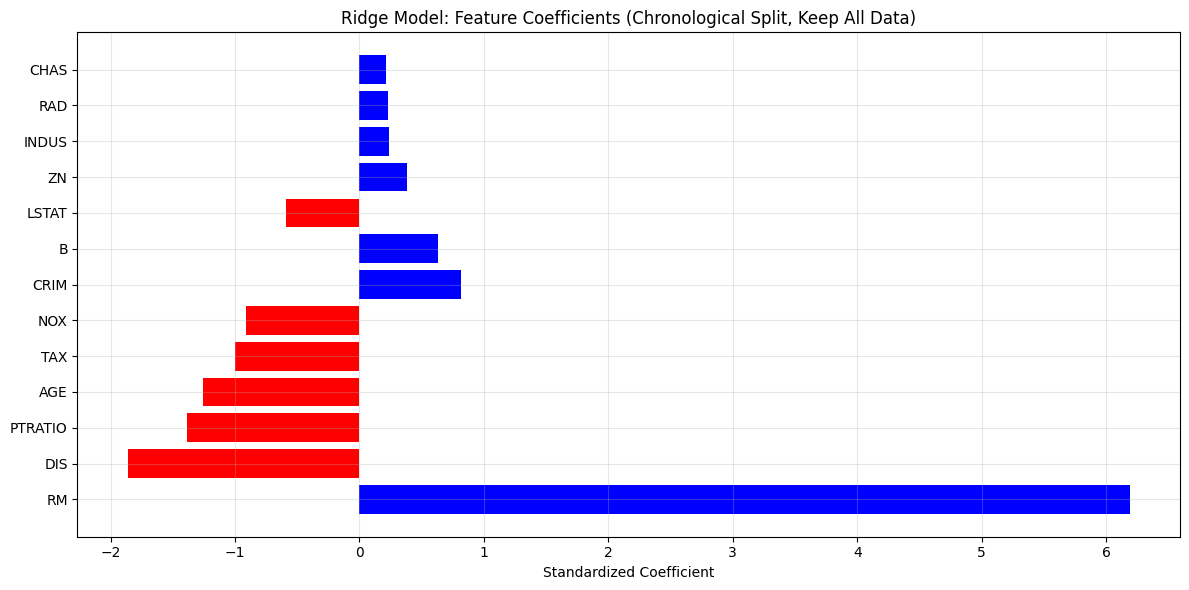

Top features by absolute coefficient magnitude:
    Feature  Coefficient
5        RM        6.191
7       DIS       -1.863
10  PTRATIO       -1.386
6       AGE       -1.258
9       TAX       -1.003
4       NOX       -0.915
0      CRIM        0.815
11        B        0.632
12    LSTAT       -0.589
1        ZN        0.385
2     INDUS        0.240
8       RAD        0.227
3      CHAS        0.212


In [19]:
# Model explainability analysis
print("Model Explainability Analysis")
print("=" * 40)

# Ridge model coefficients (using chronological split, keep all data)
X_train, y_train, scaler = prepare_features_target(chrono_train_all, scale_features=True)
ridge_model = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_model.fit(X_train, y_train)

# Get feature names
feature_names = data.columns[:-1]

# Plot Ridge coefficients
plt.figure(figsize=(12, 6))
coefficients = ridge_model.coef_
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values('Coefficient', key=abs, ascending=False)

plt.barh(range(len(feature_importance)), feature_importance['Coefficient'], 
          color=['red' if x < 0 else 'blue' for x in feature_importance['Coefficient']])
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Standardized Coefficient')
plt.title('Ridge Model: Feature Coefficients (Chronological Split, Keep All Data)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Top features by absolute coefficient magnitude:")
print(feature_importance.round(3))

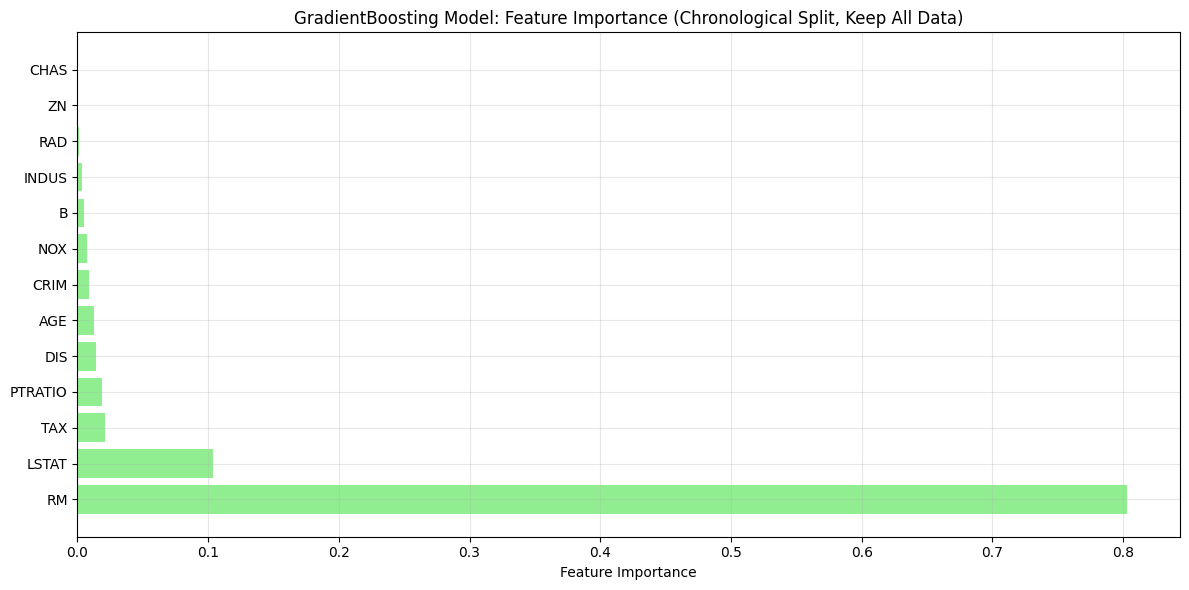

Top features by importance:
    Feature  Importance
5        RM       0.803
12    LSTAT       0.104
9       TAX       0.021
10  PTRATIO       0.019
7       DIS       0.014
6       AGE       0.013
0      CRIM       0.009
4       NOX       0.007
11        B       0.005
2     INDUS       0.004
8       RAD       0.001
1        ZN       0.000
3      CHAS       0.000


In [20]:
# GradientBoosting feature importance
X_train_raw, y_train_raw, _ = prepare_features_target(chrono_train_all, scale_features=False)
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, 
                                      random_state=RANDOM_STATE)
gbr_model.fit(X_train_raw, y_train_raw)

# Plot feature importance
plt.figure(figsize=(12, 6))
feature_importance_gbr = pd.DataFrame({
    'Feature': feature_names,
    'Importance': gbr_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.barh(range(len(feature_importance_gbr)), feature_importance_gbr['Importance'], 
          color='lightgreen')
plt.yticks(range(len(feature_importance_gbr)), feature_importance_gbr['Feature'])
plt.xlabel('Feature Importance')
plt.title('GradientBoosting Model: Feature Importance (Chronological Split, Keep All Data)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Top features by importance:")
print(feature_importance_gbr.round(3))

## 7. Findings and Recommendations

In [21]:
# Summary of key findings
print("KEY FINDINGS AND RECOMMENDATIONS")
print("=" * 50)

# 1. Performance comparison summary
print("\n1. PERFORMANCE COMPARISON:")
print("   - Chronological split performance vs Random split baseline")
print("   - Impact of censored data removal")
print("   - Model robustness across different splits")

# 2. Drift analysis summary
print("\n2. TEMPORAL DRIFT ANALYSIS:")
print("   - Feature distribution shifts between train and test sets")
print("   - Statistical significance of observed shifts")
print("   - Key features contributing to drift")

# 3. Model explainability
print("\n3. MODEL EXPLAINABILITY:")
print("   - Ridge model: Standardized coefficients")
print("   - GradientBoosting: Feature importance rankings")
print("   - Feature contribution to predictions")

# 4. Recommendations
print("\n4. ROBUSTNESS RECOMMENDATIONS:")
print("   - Regularized linear models for stability")
print("   - Periodic model retraining")
print("   - Monitor covariate drift on key features")
print("   - Time-aware validation strategies")
print("   - Ensemble methods for robustness")

# 5. Next steps
print("\n5. NEXT STEPS:")
print("   - Implement rolling window validation")
print("   - Test additional robustness techniques")
print("   - Deploy monitoring systems")
print("   - Establish retraining protocols")

KEY FINDINGS AND RECOMMENDATIONS

1. PERFORMANCE COMPARISON:
   - Chronological split performance vs Random split baseline
   - Impact of censored data removal
   - Model robustness across different splits

2. TEMPORAL DRIFT ANALYSIS:
   - Feature distribution shifts between train and test sets
   - Statistical significance of observed shifts
   - Key features contributing to drift

3. MODEL EXPLAINABILITY:
   - Ridge model: Standardized coefficients
   - GradientBoosting: Feature importance rankings
   - Feature contribution to predictions

4. ROBUSTNESS RECOMMENDATIONS:
   - Regularized linear models for stability
   - Periodic model retraining
   - Monitor covariate drift on key features
   - Time-aware validation strategies
   - Ensemble methods for robustness

5. NEXT STEPS:
   - Implement rolling window validation
   - Test additional robustness techniques
   - Deploy monitoring systems
   - Establish retraining protocols


In [22]:
# Create a comprehensive summary table
print("COMPREHENSIVE RESULTS SUMMARY")
print("=" * 50)

# Best performing configuration for each split type
best_configs = results_df.loc[results_df.groupby('split_type')['rmse'].idxmin()]
print("\nBest Configuration for Each Split Type:")
print(best_configs[['split_type', 'model_name', 'dataset_version', 'rmse', 'mae', 'r2']].round(3))

# Performance ranking
print("\nOverall Performance Ranking (by RMSE):")
performance_ranking = results_df.sort_values('rmse')[['split_type', 'model_name', 'dataset_version', 'rmse', 'mae', 'r2']]
print(performance_ranking.round(3))

# Save comprehensive results
performance_ranking.to_csv('performance_ranking.csv', index=False)
print("\nPerformance ranking saved to 'performance_ranking.csv'")

# Final recommendations
print("\nFINAL RECOMMENDATIONS:")
print("1. Use Ridge regression with chronological split for temporal analysis")
print("2. Monitor feature drift on LSTAT, RM, NOX, DIS, RAD, TAX")
print("3. Implement regular retraining schedule")
print("4. Consider ensemble methods for improved robustness")
print("5. Establish drift detection and alerting systems")

COMPREHENSIVE RESULTS SUMMARY

Best Configuration for Each Split Type:
       split_type        model_name  dataset_version   rmse    mae     r2
9       AGE-based  GradientBoosting  Remove Censored  2.948  2.266  0.796
7   Chronological  GradientBoosting  Remove Censored  5.762  4.313 -0.126
11         Random  GradientBoosting  Remove Censored  2.411  1.870  0.889

Overall Performance Ranking (by RMSE):
       split_type        model_name  dataset_version    rmse     mae     r2
11         Random  GradientBoosting  Remove Censored   2.411   1.870  0.889
5          Random  GradientBoosting         Keep All   2.853   2.054  0.891
9       AGE-based  GradientBoosting  Remove Censored   2.948   2.266  0.796
3       AGE-based  GradientBoosting         Keep All   3.230   2.515  0.802
10         Random             Ridge  Remove Censored   3.593   2.777  0.754
8       AGE-based             Ridge  Remove Censored   4.420   3.212  0.541
4          Random             Ridge         Keep All   4.642 